In [1]:
import pandas as pd
import datasets
import matplotlib.pyplot as plt
import numpy as np
import string

## Loading Data

We also annotation models with their sizes.

First, some post-processing to remove excluded prompts.

In [2]:
excludes_df = pd.read_csv("../computed_data/exclude.csv")

excludes_by_problem = excludes_df.groupby("problem").agg({"text": list}).reset_index()
excludes_by_problem = {row["problem"]: row["text"] for _, row in excludes_by_problem.iterrows()}

def string_inclusion_ignore_punctuation(s1, s2):
    # Remove punctuation
    s1 = s1.translate(str.maketrans('', '', string.punctuation))
    s2 = s2.translate(str.maketrans('', '', string.punctuation))
    # Check for inclusion and ignore newlines
    return s1.strip() in s2

def do_exclude(item):
    problem = item["problem"]
    text = item["prompt"]
    if problem in excludes_by_problem:
        for exclude in excludes_by_problem[problem]:
            if string_inclusion_ignore_punctuation(exclude, text):
                return True
    return False

In [3]:
interactions_df = datasets.load_dataset("nuprl/StudentEval", split="test").to_pandas()
gpt35turbo_df = pd.read_csv("../computed_data/executions_gpt35turbo-0301.csv", index_col=0)
starcoderbase_df = pd.read_csv("../computed_data/executions_starcoderbase.csv", index_col=0)
starcoderbase_1b_df = pd.read_csv("../computed_data/executions_starcoderbase-1b.csv", index_col=0)
starcoderbase_3b_df = pd.read_csv("../computed_data/executions_starcoderbase-3b.csv", index_col=0)
starcoderbase_7b_df = pd.read_csv("../computed_data/executions_starcoderbase-7b.csv", index_col=0)
santacoder_df = pd.read_csv("../computed_data/executions_santacoder.csv", index_col=0)
replitcode1_df = pd.read_csv("../computed_data/executions_replitcode1.csv", index_col=0)
starchat_alpha_df = pd.read_csv("../computed_data/executions_starchat-alpha.csv", index_col=0)
code_llama_py_7b_df = pd.read_csv("../computed_data/executions_code-llama-py-7b.csv", index_col=0)
code_llama_py_13b_df = pd.read_csv("../computed_data/executions_code-llama-py-13b.csv", index_col=0)
code_llama_py_34b_df = pd.read_csv("../computed_data/executions_code-llama-py-34b.csv", index_col=0)
phi1_df = pd.read_csv("../computed_data/executions_phi-1.csv", index_col=0)
gpt35turbo_df["model"] = "GPT-3.5-Turbo-0301"
gpt35turbo_df["size"] = "?"
starcoderbase_df["model"] = "StarCoderBase"
starcoderbase_df["size"] = "15.5B"
starcoderbase_1b_df["model"] = "StarCoderBase-1B"
starcoderbase_1b_df["size"] = "1B"
starcoderbase_3b_df["model"] = "StarCoderBase-3B"
starcoderbase_3b_df["size"] = "3B"
starcoderbase_7b_df["model"] = "StarCoderBase-7B"
starcoderbase_7b_df["size"] = "7B"
code_llama_py_7b_df["model"] = "Code-Llama-Py-7B"
code_llama_py_7b_df["size"] = "7B"
code_llama_py_13b_df["model"] = "Code-Llama-Py-13B"
code_llama_py_13b_df["size"] = "13B"
code_llama_py_34b_df["model"] = "Code-Llama-Py-34B"
code_llama_py_34b_df["size"] = "34B"
santacoder_df["model"] = "SantaCoder"
santacoder_df["size"] = "1.1B"
replitcode1_df["model"] = "Replit-Code-v1"
replitcode1_df["size"] = "2.7B"
starchat_alpha_df["model"] = "StarChat-Alpha"
starchat_alpha_df["size"] = "15.5B"
phi1_df["model"] = "Phi-1"
phi1_df["size"] = "1.3B"
# Remember that completions in interactions_df are from code-davinci-002 and the completions
# in these are from the respective models.
raw_exitcodes_df = pd.concat([
    gpt35turbo_df,
    starcoderbase_df,
    starcoderbase_1b_df,
    starcoderbase_3b_df,
    starcoderbase_7b_df,
    santacoder_df,
    replitcode1_df,
    starchat_alpha_df,
    code_llama_py_7b_df,
    code_llama_py_13b_df,
    code_llama_py_34b_df,
    phi1_df,
])

# Some of data includes tutorial problems.
raw_exitcodes_df = raw_exitcodes_df[~raw_exitcodes_df["problem"].isin(["apply_operations", "count_consecutive", "shorten_url"])]

print(raw_exitcodes_df.columns, len(raw_exitcodes_df))

Index(['problem', 'prompt', 'count', 'exit_code', 'model', 'size'], dtype='object') 500049


In [16]:
raw_exitcodes_df.columns

Index(['problem', 'prompt', 'count', 'exit_code', 'model', 'size', 'exclude'], dtype='object')

In [11]:
raw_exitcodes_df["exclude"] = raw_exitcodes_df.apply(do_exclude, axis=1)
exitcodes_df = raw_exitcodes_df[~raw_exitcodes_df["exclude"]]
exitcodes_df = exitcodes_df.copy()
len(exitcodes_df), len(raw_exitcodes_df)

(453551, 500049)

## Sanity Checks

We have a variable number of prompts per problem. Moreover, we are clever in `executions.py` and avoid re-executing the same program multiple times. This makes it harder to trivially verify that we have the right number of executions.

First, let's ignore executions and verify we have the right number of completions per model. The code below loads
all completions, but ignores tutorial problems which were accidentally inncluded for a few models.
They get filtered out when we subset.

In [3]:
MODELS = [
    "starcoderbase",
    "starcoderbase-7b",
    "starcoderbase-1b",
    "starcoderbase-3b",
    "santacoder",
    "replitcode1",
    "starchat-alpha",
    "gpt35turbo-0301",
    "code-llama-py-7b",
    "code-llama-py-13b",
    "code-llama-py-34b",
    "phi-1",
]
completions_list = [ ] 
for model in MODELS:
    completions = pd.read_json(f"../computed_data/completions_{model}.jsonl", lines=True)
    completions["model"] = model
    completions_list.append(completions)
completions_df = pd.concat(completions_list)
completions_df = completions_df[~completions_df["problem"].isin(["apply_operations", "count_consecutive", "shorten_url"])]
completions_df.head()

,prompt,problem,completion,model
0,"def exp(lst, val):\n """"""\n takes a list ...",exp,\n return [x**val for x in lst]\n,starcoderbase
1,"def exp(lst, val):\n """"""\n takes a list ...",exp,\n return [x ** val for x in lst]\n\n,starcoderbase
2,"def exp(lst, val):\n """"""\n takes a list ...",exp,\n return [x ** val for x in lst]\n\n,starcoderbase
3,"def exp(lst, val):\n """"""\n takes a list ...",exp,\n return [x ** val for x in lst]\n\n,starcoderbase
4,"def exp(lst, val):\n """"""\n takes a list ...",exp,\n return [x**val for x in lst]\n,starcoderbase


First we get the number of problems for each model. We 48 for each.

In [4]:
completions_df.groupby(["model"])["problem"].nunique().reset_index()

,model,problem
0,code-llama-py-13b,48
1,code-llama-py-34b,48
2,code-llama-py-7b,48
3,gpt35turbo-0301,48
4,phi-1,48
5,replitcode1,48
6,santacoder,48
7,starchat-alpha,48
8,starcoderbase,48
9,starcoderbase-1b,48


Let's get the number of completions per model. We expect these to be the same, but GPT-3.5 Turbo to have 1/10th
as many as the rest.

In [5]:
completions_df.groupby("model").size().reset_index()

,model,0
0,code-llama-py-13b,205400
1,code-llama-py-34b,205400
2,code-llama-py-7b,205400
3,gpt35turbo-0301,20360
4,phi-1,205400
5,replitcode1,203600
6,santacoder,203600
7,starchat-alpha,203600
8,starcoderbase,203600
9,starcoderbase-1b,203600


We count the number of completions for each model. We expect 200 per model.

In [6]:
completions_df.groupby(
    ["model", "prompt", "problem"]
).agg(
    {"completion": "count"}
).reset_index().groupby("model").agg(
    MinCompletions=("completion", "min"),
    MaxCompletions=("completion", "max"),
    AvgCompletions=("completion", "median"),
).reset_index()

,model,MinCompletions,MaxCompletions,AvgCompletions
0,code-llama-py-13b,200,400,200.0
1,code-llama-py-34b,200,400,200.0
2,code-llama-py-7b,200,400,200.0
3,gpt35turbo-0301,20,20,20.0
4,phi-1,200,400,200.0
5,replitcode1,200,200,200.0
6,santacoder,200,200,200.0
7,starchat-alpha,200,200,200.0
8,starcoderbase,200,200,200.0
9,starcoderbase-1b,200,200,200.0


We calculate the number of prompts per problem. These should all be the same.

In [7]:
completions_df.groupby(["model"])["prompt"].nunique().reset_index()

,model,prompt
0,code-llama-py-13b,1018
1,code-llama-py-34b,1018
2,code-llama-py-7b,1018
3,gpt35turbo-0301,1018
4,phi-1,1018
5,replitcode1,1018
6,santacoder,1018
7,starchat-alpha,1018
8,starcoderbase,1018
9,starcoderbase-1b,1018


We now validate the executions. At low temperature, it is common for a model to produce
the same completion several times. Instead of needless re-execution, we have a `count` column
that counts how many times that completion was produced for a given prompt. 

In [8]:
exitcodes_df.groupby(["model", "prompt"]).agg(
    count = pd.NamedAgg(column="count", aggfunc="sum")
).reset_index().groupby([
    "model"]
).agg(
    MinCount = pd.NamedAgg(column="count", aggfunc="min"),
    MaxCount = pd.NamedAgg(column="count", aggfunc="max"),
    AvgCount = pd.NamedAgg(column="count", aggfunc="median"))

,MinCount,MaxCount,AvgCount
model,,,
Code-Llama-Py-13B,200,400,200.0
Code-Llama-Py-34B,200,400,200.0
Code-Llama-Py-7B,200,400,200.0
GPT-3.5-Turbo-0301,20,20,20.0
Phi-1,200,400,200.0
Replit-Code-v1,200,200,200.0
SantaCoder,200,200,200.0
StarChat-Alpha,200,200,200.0
StarCoderBase,200,200,200.0


## HumanEval Performance


1. The HumanEval score for Replit-Code-v1 is from the 
   [model page](https://huggingface.co/replit/replit-code-v1-3b).

2. The GPT-3.5 HumanEval score is from the [GPT-4 technical report](https://arxiv.org/abs/2303.08774.pdf).

3. The StarCoderBase HumanEval score is from the [StarCoder technical report](https://arxiv.org/abs/2305.06161)
   and was generated with the BigCode Evaluation Harness.

4. The Code Llama results are from the [BigCode Leaderboard](https://huggingface.co/spaces/bigcode/bigcode-models-leaderboard)


We use the BigCode Evaluation Harness to compute HumanEval scores for 
StarChat-Alpha and SantaCoder using the following command:

```bash
accelerate launch main.py --tasks humaneval --max_length_generation 512 \
    --n_samples 200 --do_sample True --temperature 0.2 --precision bf16 \
    --allow_code_execution --batch_size $BATCH_SIZE --model $MODEL_NAME$
```

Results:

```json
{
  "humaneval": {
    "pass@1": 0.30018292682926834,
    "pass@10": 0.47075612230700364,
    "pass@100": 0.5635433827783558
  },
  "config": {
    "model": "/home/arjun/models/starchat-alpha",
    "temperature": 0.2,
    "n_samples": 200
  }
}
```

```json
{
  "humaneval": {
    "pass@1": 0.17817073170731706,
    "pass@10": 0.2428743895499125,
    "pass@100": 0.30546457572216273
  },
  "config": {
    "model": "bigcode/gpt_bigcode-santacoder",
    "temperature": 0.2,
    "n_samples": 200
  }
}
```

In [8]:
humaneval_df = pd.DataFrame([
    # This is what we have measured with MultiPL-E, which has different prompts.
    # { "model": "GPT-3.5-Turbo-0301", "HumanEval": "29.10" },
    { "model": "GPT-3.5-Turbo-0301", "HumanEval": "48.1" },
    { "model": "Replit-Code-v1", "HumanEval": "21.09" },
    { "model": "SantaCoder", "HumanEval": "17.81" },
    { "model": "StarChat-Alpha", "HumanEval": "30.03" },
    { "model": "StarCoderBase", "HumanEval": "30.40" },
    { "model": "StarCoderBase-7B", "HumanEval": "28.37" },
    { "model": "StarCoderBase-3B", "HumanEval": "21.46" },
    { "model": "StarCoderBase-1B", "HumanEval": "15.17" },
    { "model": "Code-Llama-Py-7B", "HumanEval": "40.48" },
    { "model": "Code-Llama-Py-13B", "HumanEval": "42.89" },
    { "model": "Code-Llama-Py-34B", "HumanEval": "53.29" },
    { "model": "Phi-1", "HumanEval": "51.22" },
])

## Calculating Pass@1

In [9]:
exitcodes_df.head()

,problem,prompt,count,exit_code,model,size,exclude
0,add_up,"def add_up(arr):\n """"""\n ""add all the do...",3,1,GPT-3.5-Turbo-0301,?,False
1,add_up,"def add_up(arr):\n """"""\n ""add all the do...",17,1,GPT-3.5-Turbo-0301,?,False
2,add_up,"def add_up(arr):\n """"""\n ""add up all the...",1,1,GPT-3.5-Turbo-0301,?,False
3,add_up,"def add_up(arr):\n """"""\n ""add up all the...",1,1,GPT-3.5-Turbo-0301,?,False
4,add_up,"def add_up(arr):\n """"""\n ""add up all the...",1,1,GPT-3.5-Turbo-0301,?,False


To avoid needless recomputations, `exitcodes_df` has a count column that counts the number of
times a model generated the same completion for the given prompt.

In [12]:
# Source: Chen at al. Evaluating Large Language Models of Code. 2021
def estimator(n: int, c: int, k: int) -> float:
    """
    Calculates 1 - comb(n - c, k) / comb(n, k).
    """
    assert c <= n, "c must be less than n"
    #if c != n and c > 0: 
    #    assert False, "c must be less than or equal to n"
    if n - c < k:
        return 1.0
    return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))

def add_pass_rates(df):
    # The success_count is zero if the exit_code is non-zero and df["count"] when it is zero.
    df["success_count"] = df.apply(lambda row: row["count"] if row["exit_code"] == 0 else 0, axis=1)
    # We are adding the c and n arguments for the estimator. n really should be either 20 or 200.
    df = df.groupby(["problem", "prompt", "model", "size"]).agg(
        c=("success_count", np.sum),
        n=("count", np.sum))
    df.reset_index(inplace=True)
    # Apply estimator to df["n"] and df["c"] to calculate df["pass1"]
    df["pass1"]  = df.apply(lambda row: estimator(row["n"], row["c"], 1), axis=1)
    df.drop(columns=["c", "n"], inplace=True)
    return df

pass_rates_df = add_pass_rates(exitcodes_df)
pass_rates_df.columns

/var/folders/vl/qws7yhb53_ldv45_94sc20sm0000gn/T/ipykernel_95948/1468078685.py:17: FutureWarning: The provided callable <function sum at 0x1121edf80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(["problem", "prompt", "model", "size"]).agg(
/var/folders/vl/qws7yhb53_ldv45_94sc20sm0000gn/T/ipykernel_95948/1468078685.py:17: FutureWarning: The provided callable <function sum at 0x1121edf80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(["problem", "prompt", "model", "size"]).agg(


Index(['problem', 'prompt', 'model', 'size', 'pass1'], dtype='object')

In [13]:
# Join pass rates with interactions on problem and prompt
annotated_pass_rates_df = interactions_df.merge(pass_rates_df, on=["problem", "prompt"])
# Drop pass NA rows
annotated_pass_rates_df = annotated_pass_rates_df[annotated_pass_rates_df["pass1"].notna()]

# There are columns "is_first_success", "is_first_failure", "is_last_success", "is_last_failure"
# Add a factor column that is the combination of these columns
def factor(row):
    if row["is_first_success"]:
        return "success (first attempt)"
    if row["is_first_failure"]:
        return "failure (first attempt)"
    if row["is_last_success"]:
        return "success (last attempt)"
    if row["is_last_failure"]:
        return "failure (last attempt)"
    return "unknown"
annotated_pass_rates_df["factor"] = annotated_pass_rates_df.apply(factor, axis=1)
annotated_pass_rates_df.head()

,problem,entrypoint,assertions,prints,username,submitted_text,tests_passed,total_tests,prompt,completion,...,last_attempt,is_success,is_first_success,is_last_success,is_first_failure,is_last_failure,model,size,pass1,factor
0,add_up,add_up,"assert add_up([ [ 'one', 2, 3, 4 ] ]) == 9\nas...","print(add_up([ [ 'one', 2, 3, 4 ] ]))\nprint(a...",student1,"takes a list of strings, integers, and floats ...",1,3,"def add_up(arr):\n """"""\n takes a list of...","return sum([x for x in arr if isinstance(x, (i...",...,False,False,False,False,True,False,Code-Llama-Py-13B,13B,0.0,failure (first attempt)
1,add_up,add_up,"assert add_up([ [ 'one', 2, 3, 4 ] ]) == 9\nas...","print(add_up([ [ 'one', 2, 3, 4 ] ]))\nprint(a...",student1,"takes a list of strings, integers, and floats ...",1,3,"def add_up(arr):\n """"""\n takes a list of...","return sum([x for x in arr if isinstance(x, (i...",...,False,False,False,False,True,False,Code-Llama-Py-34B,34B,0.0,failure (first attempt)
2,add_up,add_up,"assert add_up([ [ 'one', 2, 3, 4 ] ]) == 9\nas...","print(add_up([ [ 'one', 2, 3, 4 ] ]))\nprint(a...",student1,"takes a list of strings, integers, and floats ...",1,3,"def add_up(arr):\n """"""\n takes a list of...","return sum([x for x in arr if isinstance(x, (i...",...,False,False,False,False,True,False,Code-Llama-Py-7B,7B,0.0,failure (first attempt)
3,add_up,add_up,"assert add_up([ [ 'one', 2, 3, 4 ] ]) == 9\nas...","print(add_up([ [ 'one', 2, 3, 4 ] ]))\nprint(a...",student1,"takes a list of strings, integers, and floats ...",1,3,"def add_up(arr):\n """"""\n takes a list of...","return sum([x for x in arr if isinstance(x, (i...",...,False,False,False,False,True,False,GPT-3.5-Turbo-0301,?,0.0,failure (first attempt)
4,add_up,add_up,"assert add_up([ [ 'one', 2, 3, 4 ] ]) == 9\nas...","print(add_up([ [ 'one', 2, 3, 4 ] ]))\nprint(a...",student1,"takes a list of strings, integers, and floats ...",1,3,"def add_up(arr):\n """"""\n takes a list of...","return sum([x for x in arr if isinstance(x, (i...",...,False,False,False,False,True,False,Phi-1,1.3B,0.0,failure (first attempt)


In [14]:
mean_pass_rates_df = annotated_pass_rates_df.groupby(["factor", "model", "size"]).agg(
    pass1=("pass1", np.mean)
)
# Turn pass1 into a percentage with 2 decimals
mean_pass_rates_df["pass1"] = mean_pass_rates_df["pass1"].apply(lambda x: f"{x * 100:.2f}")
mean_pass_rates_df.reset_index(inplace=True)
# Turn factor into a column
mean_pass_rates_df = mean_pass_rates_df.pivot(index=["model", "size"], columns="factor", values="pass1")
mean_pass_rates_df.reset_index(inplace=True)
# Remove the unknown column
mean_pass_rates_df.drop(columns=["unknown"], inplace=True)
# Join with humaneval_df
mean_pass_rates_df = mean_pass_rates_df.merge(humaneval_df, on="model")
# Make model" into "model (size)"
mean_pass_rates_df["model"] = mean_pass_rates_df.apply(lambda row: f"{row['model']} ({row['size']})", axis=1)
# Remove the size column
mean_pass_rates_df.drop(columns=["size"], inplace=True)
# Rename columns to be more readable
mean_pass_rates_df.rename(columns={
    "success (first attempt)": "First Success",
    "failure (first attempt)": "First Failure",
    "success (last attempt)": "Last Success",
    "failure (last attempt)": "Last Failure",
    "model": "Model (Size)"
}, inplace=True)
# Turn into a latex table
print(mean_pass_rates_df.to_latex(index=False))
mean_pass_rates_df

/var/folders/vl/qws7yhb53_ldv45_94sc20sm0000gn/T/ipykernel_95948/2533987466.py:1: FutureWarning: The provided callable <function mean at 0x1121ef600> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mean_pass_rates_df = annotated_pass_rates_df.groupby(["factor", "model", "size"]).agg(


\begin{tabular}{llllll}
\toprule
Model (Size) & First Failure & Last Failure & First Success & Last Success & HumanEval \\
\midrule
Code-Llama-Py-13B (13B) & 10.79 & 10.71 & 70.22 & 63.08 & 42.89 \\
Code-Llama-Py-34B (34B) & 12.81 & 11.68 & 73.51 & 66.22 & 53.29 \\
Code-Llama-Py-7B (7B) & 7.36 & 9.88 & 66.88 & 56.40 & 40.48 \\
GPT-3.5-Turbo-0301 (?) & 11.91 & 13.90 & 44.84 & 48.49 & 48.1 \\
Phi-1 (1.3B) & 12.75 & 9.64 & 59.16 & 36.49 & 51.22 \\
Replit-Code-v1 (2.7B) & 4.30 & 3.24 & 33.62 & 18.85 & 21.09 \\
SantaCoder (1.1B) & 2.35 & 2.42 & 30.87 & 22.33 & 17.81 \\
StarChat-Alpha (15.5B) & 11.37 & 10.07 & 63.58 & 52.42 & 30.03 \\
StarCoderBase (15.5B) & 8.81 & 7.73 & 65.28 & 53.21 & 30.40 \\
StarCoderBase-1B (1B) & 2.00 & 1.39 & 24.86 & 13.36 & 15.17 \\
StarCoderBase-3B (3B) & 6.69 & 6.52 & 51.73 & 33.07 & 21.46 \\
StarCoderBase-7B (7B) & 6.21 & 7.86 & 62.35 & 47.70 & 28.37 \\
\bottomrule
\end{tabular}



,Model (Size),First Failure,Last Failure,First Success,Last Success,HumanEval
0,Code-Llama-Py-13B (13B),10.79,10.71,70.22,63.08,42.89
1,Code-Llama-Py-34B (34B),12.81,11.68,73.51,66.22,53.29
2,Code-Llama-Py-7B (7B),7.36,9.88,66.88,56.40,40.48
3,GPT-3.5-Turbo-0301 (?),11.91,13.90,44.84,48.49,48.1
4,Phi-1 (1.3B),12.75,9.64,59.16,36.49,51.22
5,Replit-Code-v1 (2.7B),4.30,3.24,33.62,18.85,21.09
6,SantaCoder (1.1B),2.35,2.42,30.87,22.33,17.81
7,StarChat-Alpha (15.5B),11.37,10.07,63.58,52.42,30.03
8,StarCoderBase (15.5B),8.81,7.73,65.28,53.21,30.40
9,StarCoderBase-1B (1B),2.00,1.39,24.86,13.36,15.17


/var/folders/vl/qws7yhb53_ldv45_94sc20sm0000gn/T/ipykernel_95948/1629497253.py:11: FutureWarning: The provided callable <function mean at 0x1121ef600> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  factor_df = factor_df.groupby("problem").agg(
/var/folders/vl/qws7yhb53_ldv45_94sc20sm0000gn/T/ipykernel_95948/1629497253.py:11: FutureWarning: The provided callable <function mean at 0x1121ef600> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  factor_df = factor_df.groupby("problem").agg(
/var/folders/vl/qws7yhb53_ldv45_94sc20sm0000gn/T/ipykernel_95948/1629497253.py:11: FutureWarning: The provided callable <function mean at 0x1121ef600> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used di

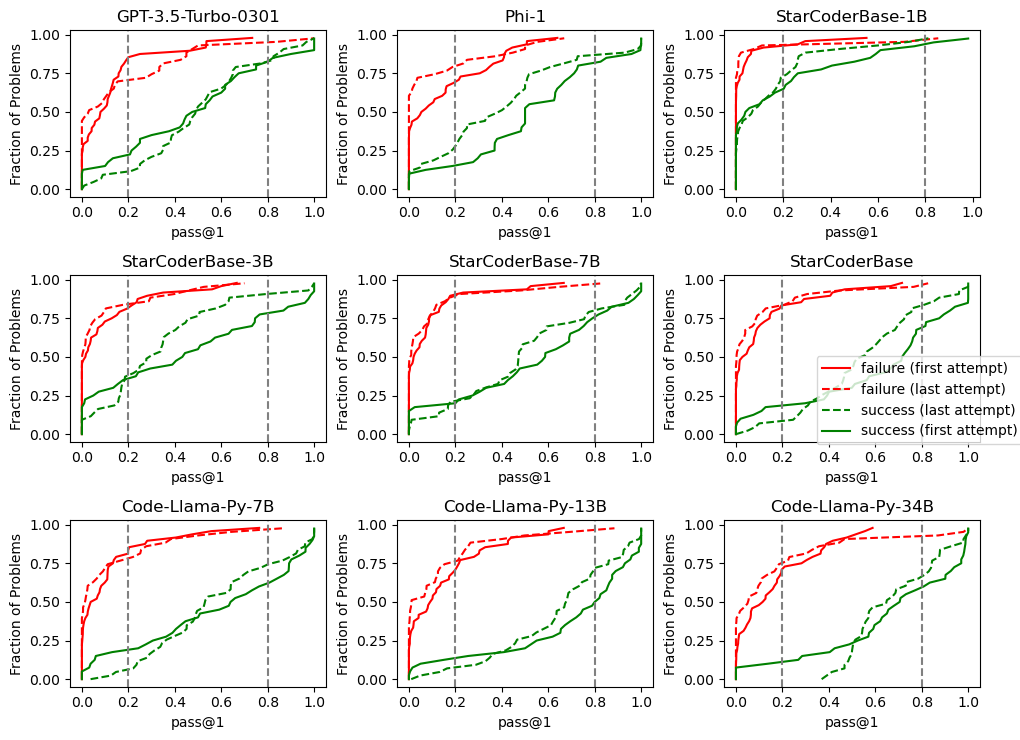

In [15]:
def plot_cdf(ax, df, model):
    """
    A CDF plot of "pass1", by each factor.
    """
    # Plot the CDF of pass1 for each factor
    df = df[df["model"] == model]
    for factor in df["factor"].unique():
        if factor == "unknown":
            continue
        factor_df = df[df["factor"] == factor]
        factor_df = factor_df.groupby("problem").agg(
            pass1=("pass1", np.mean))
        factor_df = factor_df.copy()
        factor_df.sort_values(by="pass1", inplace=True)
        factor_df.reset_index(inplace=True)
        factor_df["cdf"] = factor_df.index / len(factor_df)
        color = "green" if "success" in factor else "red"
        linestyle = "--" if "last" in factor else "-"
        ax.plot(factor_df["pass1"], factor_df["cdf"], label=factor, color=color, linestyle=linestyle)
    ax.set_xlabel("pass@1")
    ax.set_ylabel("Fraction of Problems")
    # Add a vertical line at 0.2
    ax.axvline(x=0.2, color="grey", linestyle="--")
    ax.axvline(x=0.8, color="grey", linestyle="--")
    ax.set_title(model)

fig, ax = plt.subplots(3, 3, figsize=(10, 7.5))

class NextPlot:
    def __init__(self, ax):
        self.ax = ax
        self.row = 0
        self.col = 0
    def next(self):
        r = self.row
        c = self.col
        self.col += 1
        if self.col == 3:
            self.row += 1
            self.col = 0
        return self.ax[r, c]

next_plot = NextPlot(ax)

plot_cdf(next_plot.next(), annotated_pass_rates_df, "GPT-3.5-Turbo-0301")
# plot_cdf(ax[0,2], annotated_pass_rates_df, "StarChat-Alpha")
# plot_cdf(ax[1,0], annotated_pass_rates_df, "SantaCoder")
# plot_cdf(ax[1,1], annotated_pass_rates_df, "Replit-Code-v1")
plot_cdf(next_plot.next(), annotated_pass_rates_df, "Phi-1")
plot_cdf(next_plot.next(), annotated_pass_rates_df, "StarCoderBase-1B")
plot_cdf(next_plot.next(), annotated_pass_rates_df, "StarCoderBase-3B")
plot_cdf(next_plot.next(), annotated_pass_rates_df, "StarCoderBase-7B")
plot_cdf(next_plot.next(), annotated_pass_rates_df, "StarCoderBase")
plot_cdf(next_plot.next(), annotated_pass_rates_df, "Code-Llama-Py-7B")
plot_cdf(next_plot.next(), annotated_pass_rates_df, "Code-Llama-Py-13B")
plot_cdf(next_plot.next(), annotated_pass_rates_df, "Code-Llama-Py-34B")
# Add a unified legend
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=[0.8,0.4])

fig.tight_layout()
fig.show()
# Save as pdf
fig.savefig("../figures/pass1_cdf.pdf", bbox_inches='tight')


## Variation in Pass@1

In [15]:
# Group by model, factor, and problem
reliability_df = annotated_pass_rates_df.groupby(["model", "factor", "problem"]).agg(
    pass1=("pass1", np.mean)
)
reliability_df.reset_index(inplace=True)
# Only problems with pass1 > 0.8
unreliable_df = reliability_df[reliability_df["pass1"] < 0.2]
# Group by model and factor and count
unreliable_df = unreliable_df.groupby(["model", "factor"]).agg(
    count=("problem", np.size)
)
# Drop unknown
unreliable_df.reset_index(inplace=True)
unreliable_df = unreliable_df[unreliable_df["factor"] != "unknown"]
# Sort by model then factor
unreliable_df.sort_values(by=["factor", "model"], inplace=True)
unreliable_df["Rate"] = "pass@1 < 0.2"

reliable_df = reliability_df[reliability_df["pass1"] > 0.8]
# Group by model and factor and count
reliable_df = reliable_df.groupby(["model", "factor"]).agg(
    count=("problem", np.size)
)
# Drop unknown
reliable_df.reset_index(inplace=True)
reliable_df = reliable_df[reliable_df["factor"] != "unknown"]
# Sort by model then factor
reliable_df.sort_values(by=["factor", "model"], inplace=True)
reliable_df["Rate"] = "pass@1 > 0.8"
reliability_df = pd.concat([reliable_df, unreliable_df], ignore_index=True)

#reliability_df = reliability_df.pivot(index="model", columns=["factor", "Rate"], values="count")
reliability_df.rename(columns={
    "model": "Model",
    "factor": "Subset",
    "count": "Count"
}, inplace=True)
# Order the columns
reliability_df = reliability_df[["Model", "Subset", "Rate", "Count"]]
# Pivot on Rate
reliability_df = reliability_df.pivot(index=["Model", "Subset"], columns="Rate", values="Count")
# Convert the floats in Count to ints
# Convert floats to ints or "-" if NaN
reliability_df["pass@1 < 0.2"] = reliability_df["pass@1 < 0.2"].apply(lambda x: int(x) if not np.isnan(x) else "-")
reliability_df["pass@1 > 0.8"] = reliability_df["pass@1 > 0.8"].apply(lambda x: int(x) if not np.isnan(x) else "-")
print(reliability_df.to_latex())
reliability_df


\begin{tabular}{llll}
\toprule
 & Rate & pass@1 < 0.2 & pass@1 > 0.8 \\
Model & Subset &  &  \\
\midrule
\multirow[t]{4}{*}{Code-Llama-Py-13B} & failure (first attempt) & 38 & - \\
 & failure (last attempt) & 34 & 1 \\
 & success (first attempt) & 6 & 19 \\
 & success (last attempt) & 3 & 12 \\
\cline{1-4}
\multirow[t]{4}{*}{Code-Llama-Py-34B} & failure (first attempt) & 36 & - \\
 & failure (last attempt) & 34 & 3 \\
 & success (first attempt) & 5 & 16 \\
 & success (last attempt) & - & 13 \\
\cline{1-4}
\multirow[t]{4}{*}{Code-Llama-Py-7B} & failure (first attempt) & 41 & - \\
 & failure (last attempt) & 36 & 1 \\
 & success (first attempt) & 8 & 15 \\
 & success (last attempt) & 3 & 10 \\
\cline{1-4}
\multirow[t]{4}{*}{GPT-3.5-Turbo-0301} & failure (first attempt) & 42 & - \\
 & failure (last attempt) & 31 & 2 \\
 & success (first attempt) & 9 & 6 \\
 & success (last attempt) & 5 & 7 \\
\cline{1-4}
\multirow[t]{4}{*}{Phi-1} & failure (first attempt) & 35 & - \\
 & failure (last atte

Rate                                       pass@1 < 0.2 pass@1 > 0.8
Model              Subset                                           
Code-Llama-Py-13B  failure (first attempt)           38            -
                   failure (last attempt)            34            1
                   success (first attempt)            6           19
                   success (last attempt)             3           12
Code-Llama-Py-34B  failure (first attempt)           36            -
                   failure (last attempt)            34            3
                   success (first attempt)            5           16
                   success (last attempt)             -           13
Code-Llama-Py-7B   failure (first attempt)           41            -
                   failure (last attempt)            36            1
                   success (first attempt)            8           15
                   success (last attempt)             3           10
GPT-3.5-Turbo-0301 failure (first attempt)           42            -
                   failure (last attempt)            31            2
                   success (first attempt)            9            6
                   success (last attempt)             5            7
Phi-1              failure (first attempt)           35            -
                   failure (last attempt)            37            -
                   success (first attempt)            7            7
                   success (last attempt)            13            4
Replit-Code-v1     failure (first attempt)           43            -
                   failure (last attempt)            40            -
                   success (first attempt)           18            2
                   success (last attempt)            25            -
SantaCoder         failure (first attempt)           45            -
                   failure (last attempt)            42            -
                   success (first attempt)           21            3
                   success (last attempt)            23            1
StarChat-Alpha     failure (first attempt)           38            -
                   failure (last attempt)            37            -
                   success (first attempt)            7           11
                   success (last attempt)             5            6
StarCoderBase      failure (first attempt)           41            -
                   failure (last attempt)            37            1
                   success (first attempt)            8           12
                   success (last attempt)             4            7
StarCoderBase-1B   failure (first attempt)           45            -
                   failure (last attempt)            41            1
                   success (first attempt)           26            2
                   success (last attempt)            32            1
StarCoderBase-3B   failure (first attempt)           40            -
                   failure (last attempt)            38            -
                   success (first attempt)           15            8
                   success (last attempt)            17            3
StarCoderBase-7B   failure (first attempt)           44            -
                   failure (last attempt)            39            1
                   success (first attempt)            9            9
                   success (last attempt)            10            8